In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 3 for the experiment.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import math
import json
import seaborn as sns


2023-11-19 22:02:53.347203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Set hyperparameters for this experiment
import os
units = 64
heads = 8
ff_dim = 128
dropout = 0.2
num_blocks = 3

#set save_path
save_path = "./Saved_Models_Data/Tr_U"+str(units)+"_H"+str(heads)+"_FFD"+str(ff_dim)+"_P20/"
print("Saving to: ",save_path)

#Create the necessary directory to save to:
if not os.path.exists(save_path):
    os.mkdir(save_path)
    print("Folder Created!")
else:
    print("Folder Already Exists!")

Saving to:  ./Saved_Models_Data/Tr_U64_H8_FFD128_P20/
Folder Created!


In [4]:
#Prepare Data:
path_to_X = "../Normalised/X.npy"
path_to_Y = "../Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(X_train.shape)
print(len(X_test))
print(Y_train.shape)
print(len(Y_train))
print(X_test.shape)
print(len(Y_test))
print(Y_test.shape)

# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
(49730, 50)
12433
(49730, 81)
49730
(12433, 50)
12433
(12433, 81)
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [5]:
#Positional encoding is crucial for transformer models to understand the order of the elements in a sequence.
def positional_encoding(seq_length, d_model):
     #This creates a tensor of shape (seq_length, 1) representing the positions of tokens in the sequence:
    pos = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    
    #This creates an exponential term with different frequencies:
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = pos * angle_rates
    #The angles are split into sine and cosine components. This step is crucial for capturing different positional information.
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    #Sine and cosine values are concatenated along the last axis to create the final positional encoding for a single position.
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    #Finally, a batch dimension is added to the tensor to make it compatible with batched input sequences.
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

def transformer_block(units, heads, dropout, ff_dim, name):
    inputs = layers.Input(shape=(None, units))
    #inputs = layers.Input(shape=(50, 1))  # Set the input shape explicitly
    
    #The transformer block uses a multi-head self-attention mechanism with the layers.MultiHeadAttention layer. 
    attention = layers.MultiHeadAttention(key_dim=1, num_heads=heads, dropout=dropout)(inputs, inputs)

    #Dropout is applied after self-attention, and layer normalization is performed.These help with regularization and stabilizing training.
    attention = layers.Dropout(rate=dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward
    ff = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(attention)
    ff = layers.Dropout(rate=dropout)(ff)
    #the second one restores the dimensionality. 
    ff = layers.Conv1D(filters=units, kernel_size=1)(ff)
    # dropout and layer normalization are applied for regularization.
    ff = layers.Dropout(rate=dropout)(ff)
    ff = layers.LayerNormalization(epsilon=1e-6)(attention + ff)

    model = tf.keras.Model(inputs=inputs, outputs=ff, name=name)
    return model

def build_model(units, heads, dropout, ff_dim, num_blocks, input_length=50, output_length=81):
    inputs = layers.Input(shape=(input_length, 1))
    x = inputs

    pos_encoding = positional_encoding(input_length, units)
    x = x + pos_encoding[:, :input_length, :]

    #multiple transformer blocks are stacked
    for i in range(num_blocks):
        x = transformer_block(units=units, heads=heads, dropout=dropout, ff_dim=ff_dim, name=f"transformer_block_{i}")(x)

    #After the transformer blocks, global average pooling is applied, 
    #followed by dropout and a dense layer with ReLU activation.
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    #Finally, a dense layer with a sigmoid activation function is used for the output layer, #reason why we use sigmoid function is because it exists between (0 to 1)
    outputs = layers.Dense(output_length, activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [6]:
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:2'):
        # Create the model
        model = build_model(units=units, heads=heads, dropout=dropout, ff_dim=ff_dim, num_blocks=num_blocks)
        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
        # Print model summary
        model.summary()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path+'best_tr_model.h5', save_best_only=True, verbose=1)
        
        # Training loop
        num_epochs = 200
        
        X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
        Y_train_tf = tf.convert_to_tensor(Y_train, dtype=tf.float32)
        
        history = model.fit(
            X_train_reshaped, Y_train_reshaped,
            epochs=num_epochs,
            batch_size = 32,
            validation_split=0.2,  # 20% of the data will be used for validation
            callbacks=[early_stopping, model_checkpoint]
        )
        
else:
    print("No GPU available.")

# Save the history as a JSON file
with open(save_path+'history.json','w') as file:
            json.dump(history.history, file)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-19 22:04:48.758442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 tf.__operators__.add (TFOp  (None, 50, 64)            0         
 Lambda)                                                         
                                                                 
 transformer_block_0 (Funct  (None, None, 64)          18968     
 ional)                                                          
                                                                 
 transformer_block_1 (Funct  (None, None, 64)          18968     
 ional)                                                          
                                                                 
 transformer_block_2 (Funct  (None, None, 64)          18968     
 ional)                                                      

2023-11-19 22:04:54.088885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-19 22:04:54.214913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-19 22:04:54.802264: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc2d401add0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 22:04:54.802324: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-19 22:04:54.809804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 22:04:54.934709: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1244/1244 [==============================] - ETA: 0s - loss: 0.0733 - mae: 0.1472
Epoch 1: val_loss improved from inf to 0.05947, saving model to ./Saved_Models_Data/Tr_U64_H8_FFD128_P20/best_tr_model.h5
1244/1244 [==============================] - 27s 15ms/step - loss: 0.0733 - mae: 0.1472 - val_loss: 0.0595 - val_mae: 0.1089
Epoch 2/200
   4/1244 [..............................] - ETA: 21s - loss: 0.0574 - mae: 0.1150

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1241/1244 [============================>.] - ETA: 0s - loss: 0.0547 - mae: 0.1092
Epoch 2: val_loss improved from 0.05947 to 0.05757, saving model to ./Saved_Models_Data/Tr_U64_H8_FFD128_P20/best_tr_model.h5
1244/1244 [==============================] - 17s 14ms/step - loss: 0.0547 - mae: 0.1092 - val_loss: 0.0576 - val_mae: 0.1004
Epoch 3/200
1241/1244 [============================>.] - ETA: 0s - loss: 0.0516 - mae: 0.1024
Epoch 3: val_loss did not improve from 0.05757
1244/1244 [==============================] - 18s 15ms/step - loss: 0.0516 - mae: 0.1024 - val_loss: 0.0590 - val_mae: 0.0986
Epoch 4/200
1241/1244 [============================>.] - ETA: 0s - loss: 0.0496 - mae: 0.0980
Epoch 4: val_loss improved from 0.05757 to 0.05402, saving model to ./Saved_Models_Data/Tr_U64_H8_FFD128_P20/best_tr_model.h5
1244/1244 [==============================] - 17s 14ms/step - loss: 0.0496 - mae: 0.0980 - val_loss: 0.0540 - val_mae: 0.0935
Epoch 5/200
1242/1244 [============================>.] -

In [7]:
#Double check save_path and model_name
print(save_path)
model_name = "Tr_U"+str(units)+"_H"+str(heads)+"_FFD"+str(ff_dim)+"_P20"
print(model_name)

./Saved_Models_Data/Tr_U64_H8_FFD128_P20/
Tr_U64_H8_FFD128_P20


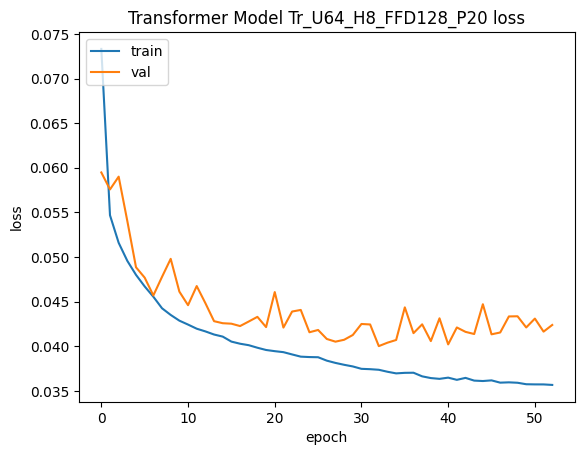

In [8]:
#plot the loss training history
f = open(save_path+"history.json")
history = json.load(f)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Transformer Model '+model_name+' loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
#Evaluate the saved best model:
from keras.models import load_model
saved_model = load_model(save_path+"best_tr_model.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 2s 4ms/step - loss: 0.0401 - mae: 0.0649
Mean Squared Error:  0.04008718952536583
Mean Absolute Error:  0.06486911326646805
Root Mean Squared Error (RMSE):  0.20021785516123639


In [10]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth.npy", Y_test)

389/389 [==============================] - 1s 3ms/step


In [11]:
#print some samples
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path +"ground-truth.npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.025472233071923256
Index 1 Ground truth: 0 Predicted: 0.24195720255374908
Index 2 Ground truth: 1 Predicted: 0.7275375723838806
Index 3 Ground truth: 0 Predicted: 3.2450000954157207e-17
Index 4 Ground truth: 0 Predicted: 3.50432088657885e-17
Index 5 Ground truth: 0 Predicted: 4.106251065083902e-14
Index 6 Ground truth: 0 Predicted: 1.3946654161406391e-12
Index 7 Ground truth: 0 Predicted: 3.2129045951512225e-11
Index 8 Ground truth: 0 Predicted: 2.2103954951113725e-14
Index 9 Ground truth: 0 Predicted: 1.1072512264703738e-12
Index 10 Ground truth: 0 Predicted: 6.523155279825055e-12
Index 11 Ground truth: 0 Predicted: 5.425438310419084e-12
Index 12 Ground truth: 0 Predicted: 1.1114259469355292e-12
Index 13 Ground truth: 1 Predicted: 0.9999998807907104
Index 14 Ground truth: 0 Predicted: 6.527437079739684e-08
Index 15 Ground truth: 0 Predicted: 9.889725149925255e-11
Index 16 Ground truth: 0 Predicted: 5.19871451931056

In [12]:
#Can convert to Benesh version for predictions using a threshold here (0.5)
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


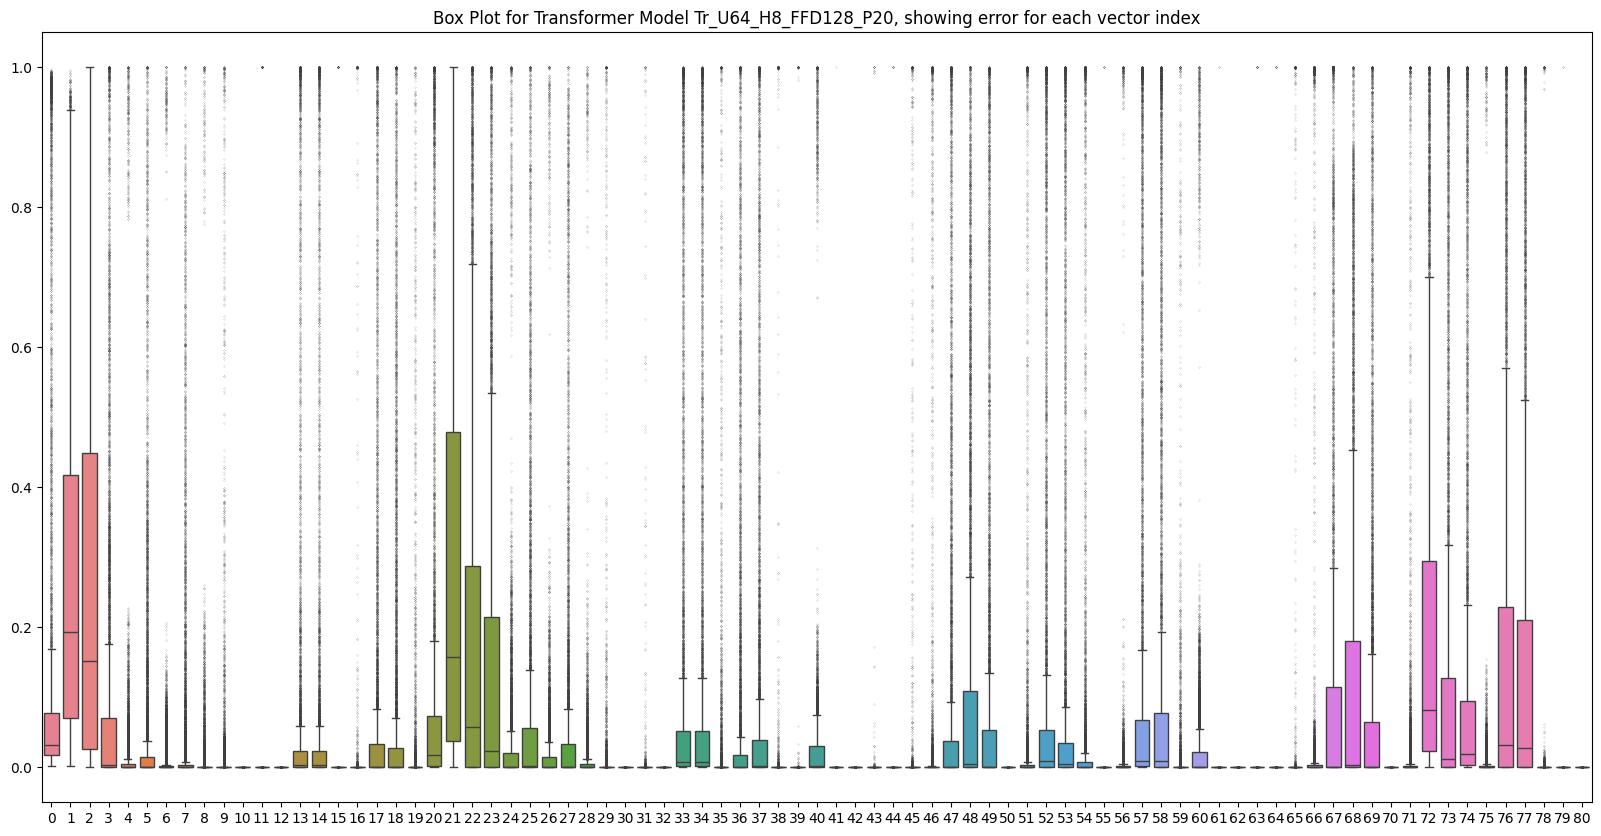

In [13]:
#save the error array and create a boxplot
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr.npy",err_arr)

err_arr = np.load(save_path+"err_arr.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for Transformer Model '+model_name+', showing error for each vector index')
plt.show()

In [14]:
#MAPE:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples*100 # Multiply by 100 to get the percentage
    print("OVERALL MAPE %: ", overall_MAPE)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.0411551  0.02596902 0.04056421 0.03450322 0.07421803 0.02727059
 0.17467118 0.1601103  0.09849566 0.05528822]
OVERALL MAPE %:  6.486910978206077


In [15]:
#R2:
from sklearn.metrics import r2_score
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.88884246 0.94207121 0.8783681  ... 0.80564243 0.80652779 0.76498976]
Overall R-squared value: 0.6823524641940389


In [16]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.61386948 0.61535237 0.61237965 ... 0.61089329 0.57522394 0.58265248]
Overall Spearman correlation coefficient: 0.5801692321587507


In [17]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.94380169 0.97152599 0.93870488 ... 0.90094613 0.89946226 0.87482877]
12433
Overall Pearson correlation coefficient: 0.8265408968232508


In [18]:
from sklearn.metrics import matthews_corrcoef #calculated using the converted 0.5 threshold benesh vector
y_pred = np.load(save_path + "y_pred_benesh.npy")
y_true = np.load(save_path + "ground-truth.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.7880215846666642
